# Annotate samples in KIRP and KIRC as FH-deficient & look at DNA methylation

Essentially we'll perform 5 steps:

    1) Download data from TCGA
    2) Find index of FH gene, ensembl ID ENSG00000091483
    3) Visualise FH across samples
    4) Annotate cases as FH deficient
    5) Map those patients to their DNA methylation & investigate that.
    
    

## Download the data
We use the scidat package to download and annotate the data from TCGA.

Download metatdata from TCGA.
For this program to work you need to first go to: https://portal.gdc.cancer.gov/ and select the files to download.

In this example, I chose my data by using the following steps:
    1. Navigate to `Exploration` tab
    2. Selected `kidney` as the Primary Site
    3. Selected `solid tissue normal` and `primary tumor` for my Sample Type (823 cases)
    4. Clicked `View Files in Repository`
    5. **OPTIONAL**: download the mutation information --> select `Mutations` tab and click `JSON` to download mutation data
    
Since I'm only interested in RNAseq count data and Methylation beta values, I filter my files to only include these two types of files.   
    6. Selected `RNA-seq` as my Experimental Strategy
    7. Selected `HTSeq - Counts` in Workflow Type
    8. Clicked `Add all files to cart` (945 files, 815 cases)
    
Now I navigated to my cart which had 945 files in it. Since it is recomended to use th GDC-data transfer tool (which scidat uses) I only download the `manifest` and the `metadata` for my files of interest.
Before proceeding, look at how much space the files will need (e.g. for me this is 117GB) make sure the computer you are downloading on has that space available.

### Download: 
    13. `Biospecimen`
    14. `Clinical`
    15. `Sample Sheet`
    16. `Metadata`
    17. Click the `Download` button and select `Manifest`

Lastly, move all these files to a new empty directory `~/Documents/TCGA_data_download_scidat/`. 
Unzip the `Clinical` folder and delete the zipped version.
Make a new directory in `~/Documents/TCGA_data_download_scidat/` called `downloads` (we'll use this below)

### Get GDC Data Transfer Tool
If you haven't already got the GDC transfer tool, you'll need to download this, follow the instructions from TCGA on how to do this:
https://gdc.cancer.gov/access-data/gdc-data-transfer-tool

Move the downloaded GDC transfer tool to the same directory you put your manifest file in i.e. `~/Documents/TCGA_data_download_scidat/` from before.
Now we're ready to download the files and annotate them with the data we downloaded.
    
### Run download script below

The script below assumes you have put the files from above in `~/Documents/TCGA_data_download_scidat/` and that your `gdc-client` is executable.

If you are using a windows machine (or put your files in a different folder you'll need to rename that directory).

Before running the script below you will need to make sure you have edited the path to the manifest file, and the gdc_client to be located where you placed them on your computer and with their proper names
(e.g. 

In [ ]:
from scidat import Download
from scidat.api import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

# meta_dir = '~/Documents/TCGA_data_download_scidat/'

meta_dir = '' #Whatever the data directory is
manifest_file = f'{meta_dir}/manifest.tsv'
gdc_client = f'{meta_dir}./gdc-client'
download_dir = f'{meta_dir}downloads/'

clinical_file = f'{meta_dir}clinical.tsv'
sample_file = f'{meta_dir}gdc_sample_sheet.2020-04-07.tsv'
manifest_file = f'{meta_dir}gdc_manifest_20200402_003828.txt'
processed_dir = f'{meta_dir}processed/'

# scidat spits the manifest file into submanifests so that we can make multiple calls to TCGA simulateously. 
# This speeds up the download process. Note, it will use up more of your computers' processing so if you are worried
# just set the max_cnt to be more than the number of files in your manifest e.g. 100000000
download_dir = f'{meta_dir}downloads/'
download = Download(manifest_file, download_dir, download_dir, gdc_client, max_cnt=100000000)


In [ ]:
"""
----------------------------
RUN Download 
----------------------------
Only run this box if you havn't already downloaded the data
"""
download.download()

# Unzip the files and copy them to another directory
download.copy_downloads_to_new_dir(processed_dir)


In [2]:

# Download dir is where we have unzipped the downloaded data to
api = API(manifest_file, gdc_client, clinical_file, sample_file, download_dir=processed_dir, meta_dir=meta_dir,
                            max_cnt=1, requires_lst=['counts'])

# Build the annotation
api.build_annotation()

# Build the RNAseq dataframe
api.build_rna_df(processed_dir)

# Now we need to access biomart to be able to mix between the two (i.e. one is annotated with gene symbol the other has ens id)
df = api.get_rna_df()



--------------------------------------------------------------------------------
                              Clinical dataframe	                               
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
   submitter_id project_id age_at_index gender          race vital_status  \
0  TCGA-CJ-4885  TCGA-KIRC           64   male         white        Alive   
2  TCGA-A3-3319  TCGA-KIRC           70   male         white        Alive   
4  TCGA-BP-4998  TCGA-KIRC           49   male         asian        Alive   
6  TCGA-CZ-4857  TCGA-KIRC           56   male         white         Dead   
8  TCGA-A3-3311  TCGA-KIRC           57   male  not reported         Dead   

  tumor_stage days_to_death  
0    stage iv            --  
2     stage i            --  
4     stage i            --  
6    stage iv          1432  
8     stage i          1191  	
--------------------------------

In [3]:
"""
--------------------------------------------------------
Add annotation to RNAseq dataframe & save Tissue counts as files.
--------------------------------------------------------
"""
# Lastly let's add some gene annotation information

"""
Annotations were generated as such:

hb = SciBiomartApi()
results_df = hb.get_human_default()
results_df = hb.sort_df_on_starts(results_df)
hb.save_as_csv(results_df, '../supps/human_')

"""

gene_id = 'ensembl_gene_id'
gene_name = 'external_gene_name'

gene_ids = []
for g in df.id.values:
    gene_ids.append(g.split('.')[0])
    
df[gene_id] = gene_ids
# Remove data that were not able to be annotated to gene names (i.e. these are usually the genes which are "unknown")


annot_df = pd.read_csv('supps/human-hsapiens_gene_ensembl-GRCh38.p13.csv')
# Merge the two
annot_df.set_index(gene_id)
annot_df[gene_id] = annot_df[gene_id].values
df = df.merge(annot_df, on=gene_id, how='inner')

# Take the largest of any that don't have a name
df = df.dropna(subset=[gene_name])

df = df.groupby([gene_id]).max()
# Note if we have duplicate results for a given condition we only take one of them.
# Now we want to add our methylation data to our dataframe, here we're being very strict and dropping any null
# rows


In [4]:

def add_meth_file(df, filename):
    # Make a dictionary from the key being the gene id to the value (width)
    mapping = {}
    # Keep the max value
    file_df = pd.read_csv(f'{meth_dir}{filename}')
    meth_values = file_df.values[:,1]
    for i, g in enumerate(file_df['id'].values):
        if not mapping.get(g):
            if g == 'PFKFB1':
                print(meth_values[i], i)
            mapping[g] = meth_values[i]
        else:
            mapping[g] = meth_values[i] if meth_values[i] > mapping[g] else mapping[g]
            if g == 'PFKFB1':
                print(i)
    # Now we want to iterate through the genes in the df and add them
    meth_values_ordered = []
    fname = file_df.columns[1]
    name = api.annotate.annotated_file_dict[fname]['label']
    for g in df[gene_name].values:
        meth_values_ordered.append(mapping.get(g))

    df[name] = meth_values_ordered
    return df

In [5]:
import os
# Now we want to add our chipseq data from Encode
meth_dir = f'{meta_dir}minified_meth/'
files = os.listdir(meth_dir)

meth_files = []
for f in files:
    if '.txt' in f and '.swp' not in f:
        meth_files.append(f)

meth_files.sort()
meth_df = pd.DataFrame()
meth_df[gene_name] = df[gene_name].values

for filename in meth_files:
    api.u.dp(["Adding", filename])
    df = add_meth_file(df, filename)


--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.TCGA-KL-8323-01A-21D-2312-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.950923962673029 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.TCGA-KL-8324-01A-11D-2312-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.94526956211726 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.TCGA-KL-8325-01A-11D-2312-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.95849523202144 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.TCGA-KL-8327-01A-11D-2312-

0.93652441592776 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.TCGA-KN-8418-01A-11D-2312-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9179828934208358 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.TCGA-KN-8419-01A-11D-2312-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.6666083114236779 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.TCGA-KN-8422-01A-11D-2312-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.930899071890497 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.TCGA-AK-3428-01A-02D-1275-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9184544462001608 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.TCGA-AK-3431-01A-02D-1275-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.728631735752741 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.TCGA-AK-3434-01A-02D-1275-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9403262220500268 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.TCGA-AK-3440-01A-02D-1

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.TCGA-B0-4714-11A-01D-1275-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.934754657823683 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.TCGA-B0-4718-01A-01D-1275-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9353824436010792 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.TCGA-B0-4718-11A-01D-1275-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.924945930020525 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.TCGA-B0-4813-01A-01D-12

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.10.lvl-3.TCGA-A3-A8OW-01A-11D-A36Y-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.936968115651192 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.10.lvl-3.TCGA-A3-A8OX-01A-11D-A36Y-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.876403797343231 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.10.lvl-3.TCGA-B8-A7U6-01A-12D-A36Y-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.789943512400292 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.10.lvl-3.TCGA-G6-A8L6-01A-11D

0.8060366765818259 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-B0-4945-01A-01D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.923766685889784 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-B0-4945-11A-01D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.8459432666835849 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-B0-5083-01A-02D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9557522660815392 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl

0.9454677408881909 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-B0-5108-11A-01D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9384197441905452 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-B0-5109-01A-02D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9310300179642808 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-B0-5109-11A-01D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.94934921430758 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-BP-4760-11A-01D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9560031692976608 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-BP-4782-01A-02D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.737275753495644 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-BP-4782-11A-01D-1418-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.8359885587294829 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.2.lvl-3.TCGA-BP-4795-01A-02D-1

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-BP-5181-01A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.924166787191411 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-BP-5181-11A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.841755069432805 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-BP-5182-01A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9514455724442192 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-BP-5182-11A-01D-14

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-BP-5200-11A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.954639397322704 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-BP-5201-01A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.96320981104204 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-BP-5201-11A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.935893795807812 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-BP-5202-01A-02D-1424

0.7943453513527359 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-CJ-4913-11A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.8705664430670609 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-CJ-4916-01A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.8890198301626571 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.TCGA-CJ-4916-11A-01D-1424-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.924883297732962 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.3.lvl

0.961415241326263 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-B0-4816-01A-01D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.958380108619177 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-B0-4816-11A-02D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9619334218275278 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-B0-4818-01A-01D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.790148673747917 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-CZ-5453-01A-01D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.967314787312718 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-CZ-5453-11A-01D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9570896265768442 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-CZ-5454-01A-01D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9636336278444332 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-CZ-5454-11A-01D-1

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-CZ-5468-11A-01D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9515530123464 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-CZ-5469-01A-01D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.965072008680016 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-CZ-5469-11A-01D-1500-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.955306325231701 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.TCGA-CZ-5470-01A-01D-1500-

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.TCGA-B2-5641-01A-01D-1536-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9444796858876948 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.TCGA-B8-5549-01A-01D-1536-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.938282632342532 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.TCGA-B8-5550-01A-01D-1536-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9351850728531852 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.TCGA-B8-5551-01A-01D-1

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.TCGA-DV-5569-01A-01D-1536-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.660171706781591 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.TCGA-DV-5573-01A-01D-1536-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.953688895545288 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.TCGA-DV-5574-01A-01D-1536-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9546708443229128 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.TCGA-DV-5575-01A-01D-15

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.6.lvl-3.TCGA-CJ-6033-01A-11D-1670-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.922962307670795 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.6.lvl-3.TCGA-CW-5580-01A-01D-1670-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.950664539678836 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.6.lvl-3.TCGA-CW-6088-01A-11D-1670-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9587116267025648 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.6.lvl-3.TCGA-CW-6090-01A-11D-16

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.8.lvl-3.TCGA-B2-3924-01A-02D-A27A-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9150045216997208 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.8.lvl-3.TCGA-B2-3924-01B-03D-A27A-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.935944241942507 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.9.lvl-3.TCGA-A3-A6NI-01A-11D-A33L-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9468202144258432 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRC.HumanMethylation450.9.lvl-3.TCGA-A3-A6NJ-01A-12D-A

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.1.lvl-3.TCGA-BQ-5882-11A-01D-1590-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9480134206433448 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.1.lvl-3.TCGA-BQ-5883-01A-11D-1590-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9147868670121702 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.1.lvl-3.TCGA-BQ-5883-11A-01D-1590-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.864251711987854 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.1.lvl-3.TCGA-BQ-5884-11A-01D-1

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.10.lvl-3.TCGA-O9-A75Z-01A-11D-A341-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9441494019753072 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.10.lvl-3.TCGA-SX-A71R-01A-12D-A341-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9383906494916328 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.10.lvl-3.TCGA-SX-A71S-01A-11D-A341-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.954732631688966 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.10.lvl-3.TCGA-SX-A71U-01A-1

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.12.lvl-3.TCGA-SX-A7SR-01A-12D-A369-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.8945587161929399 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.12.lvl-3.TCGA-SX-A7SS-01A-11D-A369-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9300613006427578 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.12.lvl-3.TCGA-SX-A7SU-01A-11D-A369-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.869218325718273 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.12.lvl-3.TCGA-Y8-A895-01A-1

0.932236667387204 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.14.lvl-3.TCGA-UZ-A9PK-01A-11D-A383-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.935473653571536 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.14.lvl-3.TCGA-UZ-A9PL-01A-11D-A383-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.940343000259274 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.14.lvl-3.TCGA-UZ-A9PM-01A-21D-A383-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.91413460181167 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.14.lvl

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.15.lvl-3.TCGA-5P-A9KC-01A-11D-A42K-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.700343263902879 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.15.lvl-3.TCGA-5P-A9KE-01A-11D-A42K-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.920714788678284 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.15.lvl-3.TCGA-5P-A9KF-01A-11D-A42K-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.875891382823091 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.15.lvl-3.TCGA-5P-A9KH-01A-11D

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.2.lvl-3.TCGA-BQ-7053-11A-01D-1963-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.814522610300133 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.2.lvl-3.TCGA-BQ-7056-01A-11D-1963-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.6272065753805239 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.2.lvl-3.TCGA-BQ-7056-11A-01D-1963-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.820043181629533 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.2.lvl-3.TCGA-BQ-7058-01A-11D-19

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.2.lvl-3.TCGA-G7-6796-01A-11D-1963-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.961498264029534 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.2.lvl-3.TCGA-G7-6797-01A-11D-1963-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9558695275440658 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.2.lvl-3.TCGA-GL-6846-01A-11D-1963-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.954019087481177 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.2.lvl-3.TCGA-GL-6846-11A-01D-19

0.5745273266924971 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.4.lvl-3.TCGA-A4-7996-01A-11D-2202-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.8574764931951501 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.4.lvl-3.TCGA-A4-7997-01A-11D-2202-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.933571714250167 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.4.lvl-3.TCGA-G7-7501-01A-11D-2202-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9188973108199632 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.4.lvl

--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.7.lvl-3.TCGA-HE-A5NH-01A-11D-A26R-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.93137616695626 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.7.lvl-3.TCGA-HE-A5NI-01A-11D-A26R-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.92159596389081 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.7.lvl-3.TCGA-HE-A5NJ-01A-11D-A26R-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.930716561304192 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.7.lvl-3.TCGA-HE-A5NK-01A-11D-A26R-

0.943218041053374 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.9.lvl-3.TCGA-A4-A6HP-01A-11D-A31Y-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.927229345000277 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.9.lvl-3.TCGA-B1-A654-01A-11D-A31Y-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9299250346858547 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.9.lvl-3.TCGA-B1-A655-01A-11D-A31Y-05.gdc_hg38.txt	
--------------------------------------------------------------------------------
0.9085762190360258 13338
--------------------------------------------------------------------------------
Adding	jhu-usc.edu_KIRP.HumanMethylation450.9.lvl-

# Find FH gene index

Here we googled ensembl ID of FH, finding it to be: ENSG00000091483.

Now we just find the index of that gene in the ID column. Since TCGA gives use the data in terms of the exact version ID we need to first remove the .X from each name.


In [6]:
fh_idx = None
i = 0
for g in df[gene_name].values:
    if g == 'FH':
        print(g)
        fh_idx = i
    i += 1
print(i)


FH
56498


## Visualise FH across the samples

    1) Accross all KIRP samples separated by normal vs tumour
    2) Across all KIRC samples separated by normal vs tumour
    3) Across KIRP demographics
    4) Across KIRC demographics


Here you can choose to log2 + 1 the data or just keep the counts.
This saves the data to disc as well.


In [ ]:

project_folder = ''
output_folder = f'{project_folder}data/'

"""
Add annotations from the paper. 
https://www.sciencedirect.com/science/article/pii/S2211124716301279
"""

RCC_annotations = f'{project_folder}MultilevelGenomicsBasedRCCTaxonomy_supp.xlsx'

# Open the excel file and read in the specific sheet that has the annotation information
sheet = 'By patient'
annot_df = pd.read_excel(io=RCC_annotations, sheet_name=sheet, header=3)

patient_names = annot_df['Patient tumor'].values
subtypes = annot_df['final subtype call'].values

# We want to join the subtypes with the patients
annotated_df = pd.DataFrame()
annotated_df[gene_name] = df[gene_name].values
i = 0
for patient in patient_names:
    for c in df:
        if patient[:-3] in c and ('htseq.counts' in c or 'HumanMethylation450' in c):
            annotated_df[f'{subtypes[i]}_{c}'] = df[c].values
            
    i += 1

In [ ]:
df = df.fillna(0)

## Visualise the data 

    1) Create the boxplots and historgams of the vis.


In [9]:
# Also make one with just Pe2 and just cimp
pe2_df = annotated_df[[gene_name] + [s for s in annotated_df.columns if 'P-e.2' in s]]
cimp_df = annotated_df[[gene_name] + [s for s in annotated_df.columns if 'P.CIMP-e' in s]]


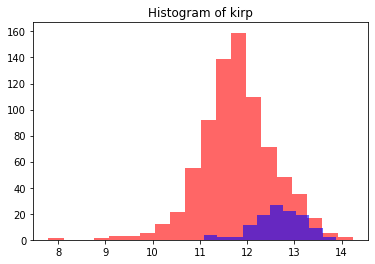

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Tumour v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.920e-31 U_stat=1.528e+04


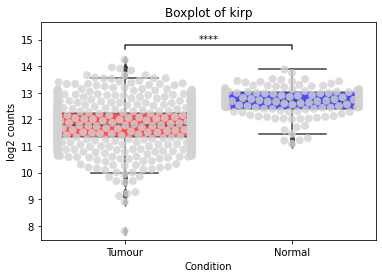

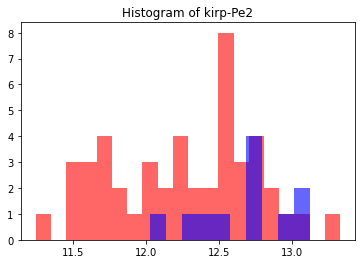

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Tumour v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.316e-02 U_stat=1.330e+02


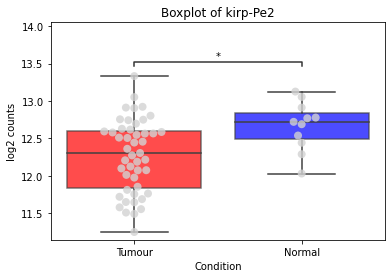

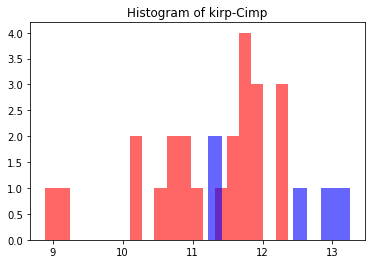

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Tumour v.s. Normal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.295e-02 U_stat=2.600e+01


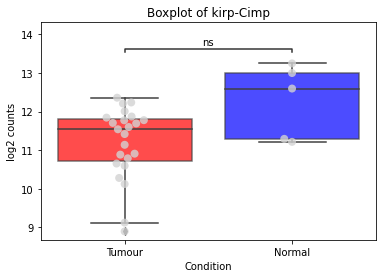

In [10]:

dfs = [annotated_df, pe2_df, cimp_df]
labels = ['kirp', 'kirp-Pe2', 'kirp-Cimp']
label_i = 0
for d in dfs:
    normal_fh = []
    tumour_fh = []
    values = d.values[fh_idx]
    c_i = 0
    cond_labels = []
    cond_values = []
    for c in d.columns:
        if 'counts' in c:
            if 'Normal' in c:
                normal_fh.append(np.log2(values[c_i] + 1))
                cond_labels.append('Normal')
                cond_values.append(np.log2(values[c_i] + 1))
            elif 'PrimaryTumor' in c:
                tumour_fh.append(np.log2(values[c_i] + 1))
                cond_labels.append('Tumour')
                cond_values.append(np.log2(values[c_i] + 1))
        c_i += 1
    plt.hist(tumour_fh, bins=20, alpha=0.6, color='r')
    plt.hist(normal_fh, bins=10, alpha=0.6, color='b')

    plt.savefig(f'{output_folder}histogram_{labels[label_i]}.png')
    plt.title(f'Histogram of {labels[label_i]}')
    plt.show()
    
    box_df = pd.DataFrame()
    box_df['Condition'] = cond_labels
    box_df['log2 counts'] = cond_values
    # Let's also just make a box plot as well to see if there is a sig diff
    ax = sns.boxplot(data=box_df, x='Condition', y='log2 counts', order=['Tumour', 'Normal'], boxprops=dict(alpha=.7))
    plt.title(f'Boxplot of {labels[label_i]}')
    add_stat_annotation(ax, data=box_df, x='Condition', y='log2 counts', order=['Tumour', 'Normal'],
                    box_pairs=[("Tumour", "Normal")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    ax.artists[0].set_facecolor('r')
    ax.artists[1].set_facecolor('b')
    sns.swarmplot(data=box_df, x='Condition', y='log2 counts', order=['Tumour', 'Normal'],
              size=8, linewidth=0, color="lightgrey", edgecolor="gray", alpha=0.8)
    plt.savefig(f'{output_folder}boxplot_{labels[label_i]}.png')
    plt.show()
    label_i += 1
    

In [12]:
pe2_df.to_csv('data/P-e.2_TCGA.RNA.DNAMethylation.csv')

In [2]:
pe2_df = pd.read_csv('data/annotated-rna_kirp-Pe2_20200814.csv')
pe2_df

,gene_id,gene_name,FHgrt11.8_P-e.2_TCGA-KIRC_PrimaryTumor_male_blackorafricanamerican_1_htseq.counts_735_TCGA-KIRC_TCGA-A3-3313_2671dda7-926b-4b95-9b0c-5ebe9a40f0c2,FHgrt11.8_P-e.2_TCGA-KIRC_PrimaryTumor_male_blackorafricanamerican_2_htseq.counts_--_TCGA-KIRC_TCGA-AK-3456_7b71cfe6-4fdd-4c2b-9b46-d7589c896174,FHleq11.8_P-e.2_TCGA-KIRC_PrimaryTumor_female_blackorafricanamerican_1_htseq.counts_51_TCGA-KIRC_TCGA-B2-4098_6d9015d6-2470-4ebb-8e07-360cde9ab13f,FHgrt11.8_P-e.2_TCGA-KIRC_SolidTissueNormal_female_white_4_htseq.counts_552_TCGA-KIRC_TCGA-CJ-5681_48a60ec9-abe8-4c67-907d-eefd97b7a107,FHgrt11.8_P-e.2_TCGA-KIRC_PrimaryTumor_female_white_4_htseq.counts_552_TCGA-KIRC_TCGA-CJ-5681_c3641a4d-1af6-474a-9313-4d1877b69bd4,FHgrt11.8_P-e.2_TCGA-KIRC_PrimaryTumor_female_white_1_htseq.counts_--_TCGA-KIRC_TCGA-B4-5835_86c8062c-ae80-45c6-a35b-591043a9649d,FHgrt11.8_P-e.2_TCGA-KIRC_PrimaryTumor_female_blackorafricanamerican_1_htseq.counts_--_TCGA-KIRC_TCGA-B8-A54E_e29ee40c-a51c-490e-b29e-d0d1c12de8ac,FHgrt11.8_P-e.2_TCGA-KIRC_PrimaryTumor_female_blackorafricanamerican_1_htseq.counts_--_TCGA-KIRC_TCGA-6D-AA2E_651d7063-0803-459e-b03a-b2c81ddf87a5,...,FHleq11.8_P-e.2_TCGA-KIRP_PrimaryTumor_male_white_1_htseq.counts_--_TCGA-KIRP_TCGA-Y8-A8S1_113e20dd-1cea-4ae6-95b1-8c17f5b36f88,FHgrt11.8_P-e.2_TCGA-KIRP_PrimaryTumor_male_asian_3_htseq.counts_--_TCGA-KIRP_TCGA-F9-A97G_1ae69dce-655a-4175-b175-d513e8a069cc,FHgrt11.8_P-e.2_TCGA-KIRP_PrimaryTumor_male_white_1_htseq.counts_--_TCGA-KIRP_TCGA-2Z-A9JD_c02afc0a-11c5-4fcc-8986-287d79875b19,FHgrt11.8_P-e.2_TCGA-KIRP_PrimaryTumor_female_blackorafricanamerican_1_htseq.counts_--_TCGA-KIRP_TCGA-2Z-A9JO_68296760-4635-4a8e-bafb-839aef7b2b75,FHleq11.8_P-e.2_TCGA-KIRP_PrimaryTumor_female_white_1_htseq.counts_589_TCGA-KIRP_TCGA-5P-A9K9_8e994ca2-33c6-4ff3-9028-caaee46b93c9,FHgrt11.8_P-e.2_TCGA-KIRP_PrimaryTumor_female_white_1_htseq.counts_--_TCGA-KIRP_TCGA-5P-A9KC_1e43f447-863c-4de8-a607-0fd210444de7,FHleq11.8_P-e.2_TCGA-KIRP_PrimaryTumor_male_white_1_htseq.counts_--_TCGA-KIRP_TCGA-P4-AAVO_49be8b02-bb76-49a4-869b-5995a59ec10c,FHgrt11.8_P-e.2_TCGA-KIRP_PrimaryTumor_male_blackorafricanamerican_3_htseq.counts_2624_TCGA-KIRP_TCGA-UZ-A9PQ_a8813427-dfd6-416a-8a06-ffcad7cd4e16,FHgrt11.8_P-e.2_TCGA-KIRP_PrimaryTumor_female_white_1_htseq.counts_--_TCGA-KIRP_TCGA-UZ-A9Q1_af77b60e-93d7-45af-bfd9-879078338349,FHgrt11.8_P-e.2_TCGA-KIRP_PrimaryTumor_female_white_1_htseq.counts_--_TCGA-KIRP_TCGA-WN-AB4C_ee82feda-b712-4432-91f6-3dfa9d5dccbb
0,ENSG00000000003.13,TSPAN6,3225,4059,2020,4104,2974,10472,2379,2332,...,1804,3918,2006,2830,4114,3125,3467,2603,4053,2079
1,ENSG00000000005.5,TNMD,0,15,0,14,0,12,0,1,...,0,4,0,3,27,1,1,1,6,0
2,ENSG00000000419.11,DPM1,1490,985,958,1420,1472,1726,1927,1107,...,695,1599,1153,1238,1445,1272,1011,1609,1258,449
3,ENSG00000000457.12,SCYL3,832,547,480,625,829,780,757,455,...,175,656,415,313,403,635,150,882,390,168
4,ENSG00000000460.15,C1orf112,258,125,131,272,197,521,903,126,...,61,143,91,76,284,167,36,203,83,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56535,ENSG00000281904.1,AC233263.6,0,0,0,0,0,0,0,1,...,0,0,0,0,0,3,0,8,0,0
56536,ENSG00000281909.1,HERC2P7,1,0,2,0,1,0,0,0,...,0,3,1,0,1,0,0,2,0,0
56537,ENSG00000281910.1,SNORA50A,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
56538,ENSG00000281912.1,LINC01144,112,25,39,70,344,42,36,99,...,50,18,54,196,47,35,48,31,65,135


## Set samples to be FH deficient or not

    1) Based on the above boxplots we can choose a stricter cutoff of 10, or a more 
        relaxed cutoff of 11.
    2) Run the cutoff for each dataframe
    

In [ ]:
from scipy.stats import iqr

# Keep track of the patient IDs so that we can map this to our DNA methylation data
fh_deficient_patients = {}
fh_normal_patients = {}
for label in labels:
    fh_deficient_patients[label] = []
    fh_normal_patients[label] = []

label_i = 0
for d in dfs:
    values = d[[s for s in d.columns if 'Normal' in s or 'Primary' in s and 'counts' in s]].values[fh_idx]
    tumour_values = d[[s for s in d.columns if 'Primary' in s and 'counts' in s]].values[fh_idx]
    c_i = 0
    cond_labels = []
    cond_values = []
    new_df = pd.DataFrame()
    new_df[gene_name] = d[gene_name].values

    cutoff = np.percentile(tumour_values, 25, interpolation='midpoint')
    log2_cutoff = round(np.log2(cutoff + 1), 1)
    print(log2_cutoff)
    for c in d.columns:
        fh_value = values[c_i]
        if 'counts' in c:
            if 'Normal' in c or 'PrimaryTumor' in c:
                if fh_value > cutoff:
                    new_df[f'FHgrt{log2_cutoff}_{c}'] = d[c].values
                    # Add this patient ID to the deficient group
                    fh_normal_patients[labels[label_i]].append(c.split('_')[-2])
                else:
                    new_df[f'FHleq{log2_cutoff}_{c}'] = d[c].values
                    # Add this patient ID to the deficient group
                    fh_deficient_patients[labels[label_i]].append(c.split('_')[-2])
            c_i += 1
    # Save dataframe
    # api.u.save_df(new_df, api.u.generate_label([output_folder, f'annotated-rna-meth_{labels[label_i]}'],'.csv'))
    label_i += 1
    


## Look at the FH expression and other expressions
Validate that our grouping is correct.

In [12]:
import pandas as pd 

# Read in the annotated dataframe
pe2_df = pd.read_csv('data/annotated-rna_kirp-Pe2_20200814.csv')

fh_df = pe2_df[pe2_df['gene_name'] == 'FH']
fh_df
values = []
labels = []
states = []
for c in fh_df.columns:
    if 'TCGA' in c:
        labels.append(c.split('_')[0])
        values.append(hira[c].values[0])
        states.append(c.split('_')[3])

<AxesSubplot:xlabel='FH', ylabel='RNA'>

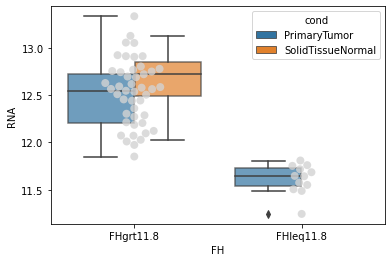

In [13]:
import seaborn as sns
box_df = pd.DataFrame()
box_df['RNA'] = np.log2(np.array(values) + 1)
box_df['FH'] = labels
box_df['cond'] = states

# Here we see that low FH is low 
ax = sns.boxplot(data=box_df, x='FH', y='RNA', hue='cond', boxprops=dict(alpha=.7))
sns.swarmplot(data=box_df, x='FH', y='RNA',
              size=8, linewidth=0, color="lightgrey", edgecolor="gray", alpha=0.8)

<AxesSubplot:xlabel='HIRA', ylabel='RNA'>

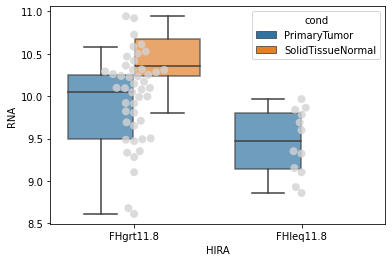

In [24]:
import seaborn as sns
hira = pe2_df[pe2_df['gene_name'] == 'HIRA']

values = []
labels = []
states = []
for c in hira.columns:
    if 'TCGA' in c:
        labels.append(c.split('_')[0])
        values.append(hira[c].values[0])
        states.append(c.split('_')[3])
        
box_df = pd.DataFrame()
box_df['RNA'] = np.log2(np.array(values) + 1)
box_df['HIRA'] = labels
box_df['cond'] = states


ax = sns.boxplot(data=box_df, x='HIRA', y='RNA', hue='cond', boxprops=dict(alpha=.7))
sns.swarmplot(data=box_df, x='HIRA', y='RNA',
              size=8, linewidth=0, color="lightgrey", edgecolor="gray", alpha=0.8)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

FHgrt11.8 v.s. FHleq11.8: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.618e-03 U_stat=3.240e+02


(<AxesSubplot:xlabel='HIRA', ylabel='RNA'>,
 [<statannot.StatResult.StatResult at 0x7fcde8673518>])

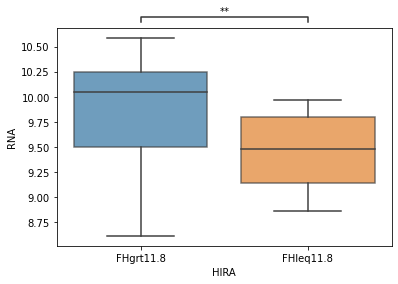

In [25]:
import seaborn as sns
from statannot import add_stat_annotation

values = []
labels = []
states = []
for c in hira.columns:
    if 'TCGA' in c:
        labels.append(c.split('_')[0])
        values.append(hira[c].values[0])
        states.append(c.split('_')[3])
        
box_df = pd.DataFrame()
box_df['RNA'] = np.log2(np.array(values) + 1)
box_df['HIRA'] = labels
box_df['cond'] = states

box_df = box_df[box_df['cond'] == 'PrimaryTumor']
ax = sns.boxplot(data=box_df, x='HIRA', y='RNA', boxprops=dict(alpha=.7))
# sns.swarmplot(data=box_df, x='HIRA', y='RNA',
#               size=8, linewidth=0, color="lightgrey", edgecolor="gray", alpha=0.8)
add_stat_annotation(ax, data=box_df, x='HIRA', y='RNA', box_pairs = [('FHgrt11.8', 'FHleq11.8')], 
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
